In [32]:
# Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [26]:
# Data Pre-processing
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# Inputed missing bmi with the median values of other bmi
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
# Drop the Null Values
df = df.dropna()
# Drop the 'Other' values in the 'gender' column
df = df.drop(df.index[df['gender'] == 'Other'])
df = df.drop(df.index[df['smoking_status'] == 'Unknown'])
# Assign dummy variables to the 'gender' column
dummies1 = pd.get_dummies(df['gender'], dtype=int)
clean_df = pd.concat([dummies1, df], axis=1)
clean_df = clean_df.drop(columns='gender')
# Drop the id column
clean_df = clean_df.drop(columns='id')
# Filter out age that are less than 1 and assign ages into categories
clean_df = clean_df[clean_df['age'] > 1]
bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]
names = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
df['AgeRange'] = pd.cut(df['age'], bins, labels=names)
clean_df['AgeRange'] = df['AgeRange']
clean_df

,Female,Male,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,AgeRange
0,0,1,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,61-70
1,1,0,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,61-70
2,0,1,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,71-80
3,1,0,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,41-50
4,1,0,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,71-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102,1,0,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0,51-60
5105,1,0,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0,71-80
5106,1,0,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,80+
5107,1,0,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,31-40


Text(0.5, 1.0, 'Distributin of Age')

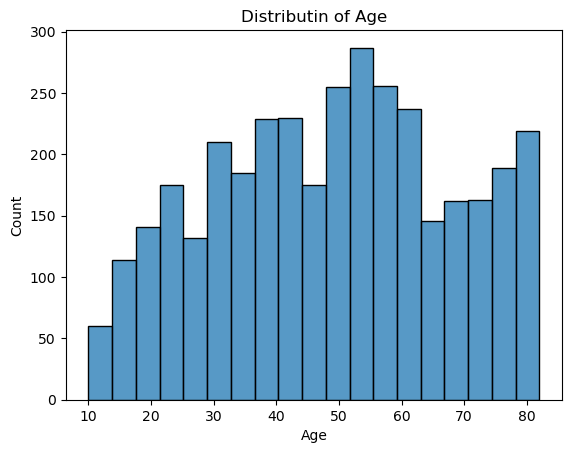

In [27]:
# Data Visualization 1: Age Distributions
df
sns.histplot(data=df, x='age')
plt.xlabel("Age")
plt.title("Distributin of Age")

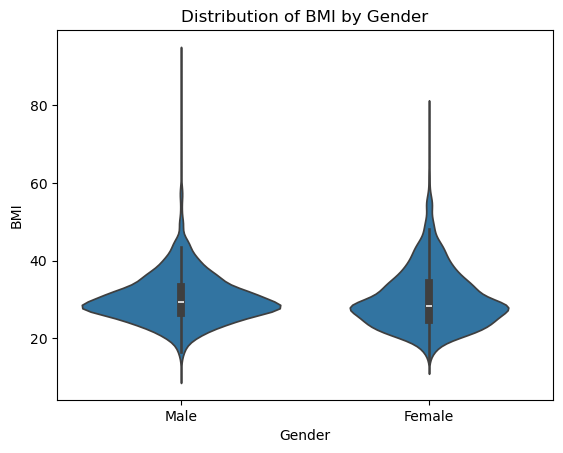

In [28]:
# Data Visualization 2: The relationship between BMI and Gender
sns.violinplot(data=df,x='gender', y='bmi')
plt.xlabel("Gender")
plt.ylabel("BMI")
plt.title("Distribution of BMI by Gender")
plt.show()

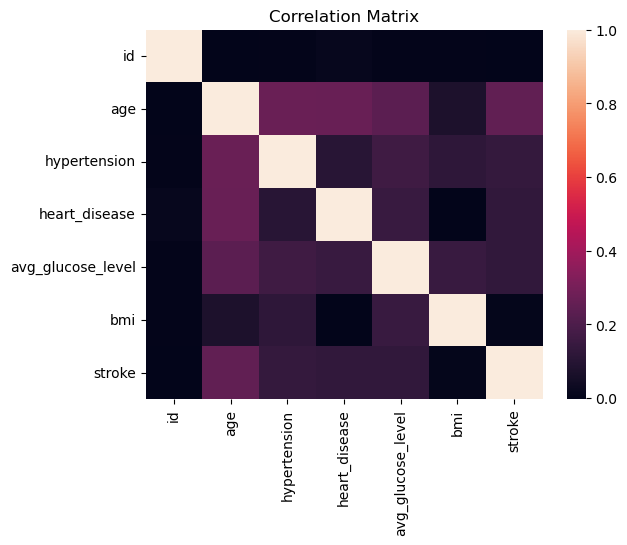

In [29]:
# Data Visualization 3: Correlation Matrix
df.dtypes
numerics = ['int64', 'float64']
corr_df = df.select_dtypes(include=numerics)
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix)
plt.title("Correlation Matrix")
plt.show()

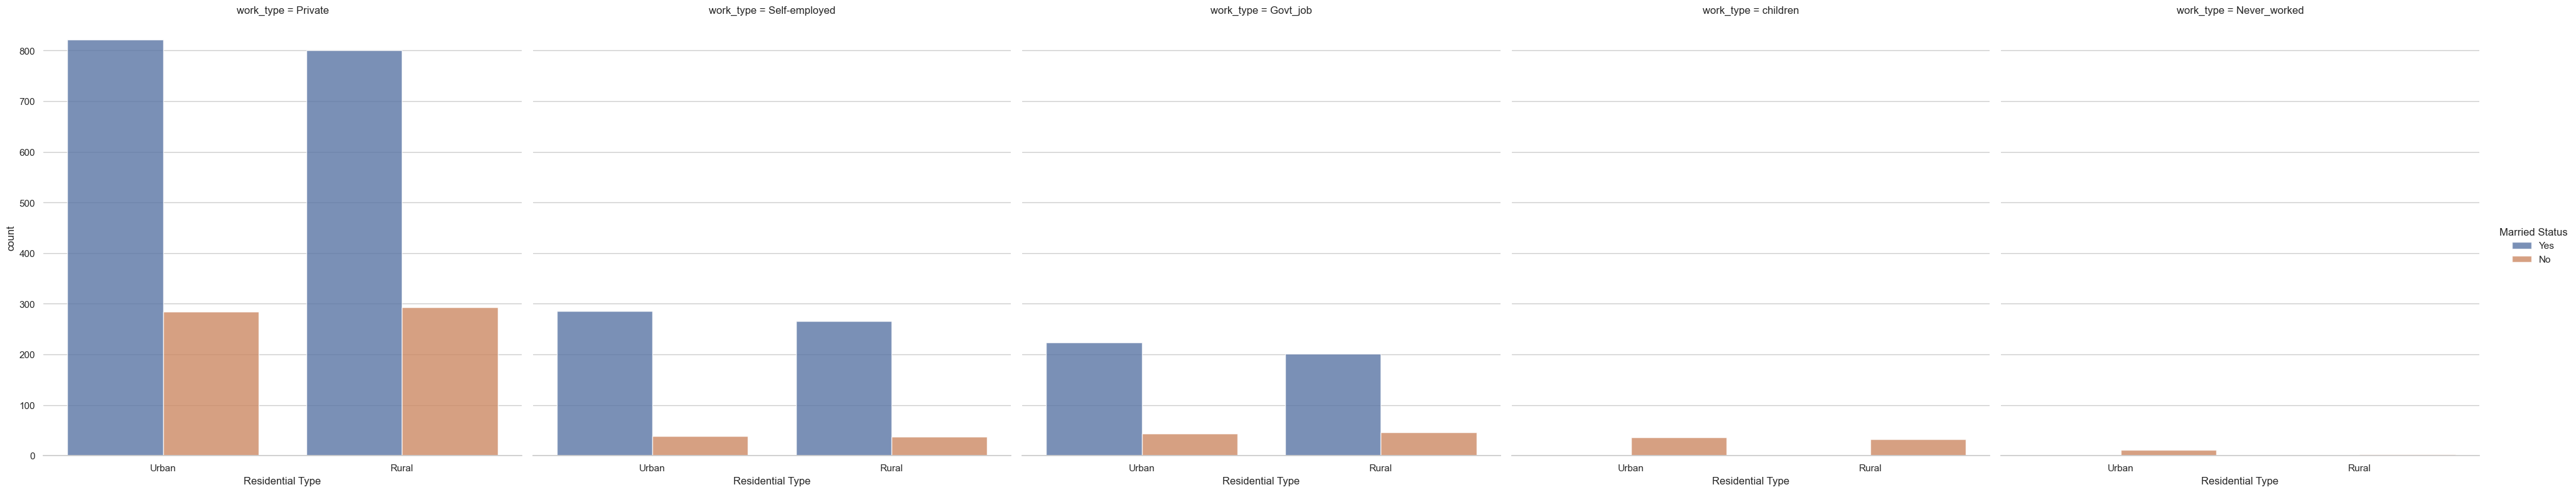

In [ ]:
# Data Visualization 4: The relationship between residence type, marital status, and work type
sns.set_theme(style="whitegrid")
plot = sns.catplot(data=df, x='Residence_type', col='work_type', 
                   hue='ever_married', kind='count', alpha=0.8, height=8)
plot.despine(left=True)
plot.set_axis_labels("Residential Type")
plot.legend.set_title("Married Status")

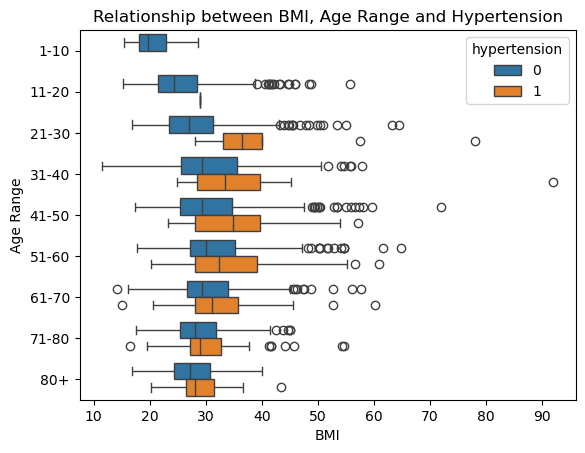

In [30]:
# Data Visualization 5: The relationship between BMI, Age Categories, and Hypertension
df = df[df['age'] > 1]
bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]
names = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
df['AgeRange'] = pd.cut(df['age'], bins, labels=names)
sns.boxplot(data=df,x='bmi', y='AgeRange', hue='hypertension')
plt.xlabel("BMI")
plt.ylabel("Age Range")
plt.title("Relationship between BMI, Age Range and Hypertension")
plt.show()

In [39]:
categorical_cols = ['ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}
for col in categorical_cols:
   le = LabelEncoder()
   clean_df[col] = le.fit_transform(df[col])
   label_encoders[col] = le

X = clean_df.drop(["stroke", "AgeRange"], axis=1)
y = clean_df["stroke"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
   X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[673   0]
 [ 40   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       673
           1       0.00      0.00      0.00        40

    accuracy                           0.94       713
   macro avg       0.47      0.50      0.49       713
weighted avg       0.89      0.94      0.92       713

ROC-AUC Score: 0.7794576523031204
Accuracy: 0.9438990182328191


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
